In [37]:
# Do this and follow instructions for render to work

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [38]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.0.0)


In [39]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import cv2

from IPython import display as ipythondisplay

In [40]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [41]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [61]:
import matplotlib.pyplot as plt
import os
import random
import gym
import tensorflow as tf
import numpy as np
import imageio
from skimage.transform import resize

Shape of image:  (210, 160, 3)


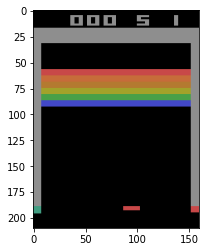

In [62]:
# Check if render indeed works by plotting initial state
env = gym.make('BreakoutDeterministic-v4')
env.reset()

def plot_initial(env):

  next_state, reward, done, info = env.step(3)

  print('Shape of image: ', next_state.shape)

  plt.imshow(next_state)
  plt.show()

plot_initial(env)

Shape of resized image:  (84, 84, 1)


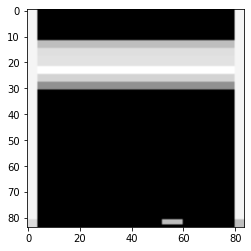

In [63]:
env.reset()

def plot_resized(env):
  next_state, reward, done, info = env.step(0)

  processed = tf.image.rgb_to_grayscale(next_state)
  processed = tf.image.crop_to_bounding_box(processed, 34, 0, 160, 160)
  processed = tf.image.resize(processed, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  print('Shape of resized image: ', processed.shape)

  plt.imshow(np.squeeze(processed), cmap='gray')
  plt.show()

plot_resized(env)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Load a trained model from path
def restore_model(path):
    model_total = []
    for saved_models in os.listdir(path):
      print('hi')
      model_path = path + "/" + saved_models
      models = [model_path + "/" + name for name in os.listdir(model_path)]
      if models:
        latest_model = max(models,key= os.path.getctime)
        model_total.append(tf.keras.models.load_model(latest_model))
      # else:
      #   return "check filepath"
    return model_total

# Make directories to save models and videos
def make_directory(path):
  if os.path.exists(path):
    return
  else:
    os.mkdir(path)

checkpoint_path = "/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/Models"
make_directory(checkpoint_path)
make_directory(checkpoint_path + "/main_model")
make_directory(checkpoint_path + "/target_model")
video_files = "/content/drive/MyDrive/Spring 2021/ECE 6254 Stat Machine Learning/Project/Videos"
make_directory(video_files)

loading_model = False

if loading_model == True:

  models = restore_model(checkpoint_path)
  model = models[0]
  model_target = models[1]

In [65]:
# Make a random agent video
def get_random_frames(env):
  env.reset()
  done = False

  f = []

  while not done:

    rand_action = env.action_space.sample()
    next_state, reward, done, info = env.step(rand_action)
    f.append(next_state)
  
  return f

f = get_frames(env)

In [66]:
# Make a video sequence from stored frames of the random agent
def make_video(frames, path, epsiode_count, trial_num):

  size = frames[0].shape # Size of each image in frame
  fps = 30
  out = cv2.VideoWriter(path + '/Episode_{}_trial_{}.mp4'.format(epsiode_count, trial_num), cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0])) # Assumes RGB, need to only pass (width, height)
  for frame in frames:
      data = frame[:, :, ::-1] # assumes BGR format, so reverse channels
      out.write(data)

  out.release()

make_video(f, video_files, 2, 1)

In [67]:
# CNN Implementation, using class

# Import packages
import numpy as np
import gym

import time
import random
from collections import deque

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout


In [68]:
def CNN_agent(image_size, num_actions):
  # Architecture of the CNN, accepts a stack of 4 images(current state) and returns q value corresponding to that state
  # Inputs:
  # image_size: Size of the input image frames
  # num_actions: Number of actions
  # Outputs:
  # Compiled Architecture of the CNN

  # Architecture of the implementation
  learning_rate = 0.00001
  hidden = 1024

  input_tensor = keras.Input(shape=image_size)
  
  input_scaled = input_tensor/255 # Normalizing input

  # Convolutional layers ( Had to use tf.keras.initializers.VarianceScaling since tf.variance_scaling_initializer was not found)
  conv1  = Conv2D(filters=32, kernel_size=(8,8), strides=4, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),\
                       padding="valid", activation="relu", use_bias=False)(input_scaled) # Conv1
  conv2  = Conv2D(filters=64, kernel_size=(4,4), strides=2, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),\
                       padding="valid", activation="relu", use_bias=False)(conv1) # Conv2
  conv3  = Conv2D(filters=64, kernel_size=(3,3), strides=1, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),\
                       padding="valid", activation="relu", use_bias=False)(conv2) # Conv3
  conv4  = Conv2D(filters=hidden, kernel_size=(7,7), strides=1, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2),\
                       padding="valid", activation="relu", use_bias=False)(conv3) # Conv2

  # Splitting into value and advantage stream 
  valuestream, advantagestream = tf.split(conv4, 2, axis=3) # 2 is number of splits
  valuestream = Flatten()(valuestream)
  advantagestream = Flatten()(advantagestream)
  advantage = Dense(units=num_actions, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(advantagestream)
  value = Dense(units=1, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2))(valuestream)

  # Combining value and advantage
  q_values = value + tf.subtract(advantage, tf.reduce_mean(advantage, axis=1, keepdims=True))

  model = keras.Model(inputs=input_tensor, outputs=q_values)

  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

CNN = CNN_agent(image_size=(84,84,1), num_actions=3)
CNN.summary()


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 84, 84, 1)]  0                                            
__________________________________________________________________________________________________
tf.math.truediv_27 (TFOpLambda) (None, 84, 84, 1)    0           input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 20, 20, 32)   2048        tf.math.truediv_27[0][0]         
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 9, 9, 64)     32768       conv2d_106[0][0]                 
___________________________________________________________________________________________

In [69]:
class CNN_DQN_agent:

  def __init__(self, env_name):
    # Parameters
    # env_name: Name of the game we are playing

    self.game_name = env_name # Name of the game we are playing
    self.game = gym.make(env_name) # Create the game environment

    self.double_dqn = False # flag for Double DQN learning (slows down a lot)

    # ExplorationExploitationScheduler
    self.eps_initial = 1 # Exploration probability for the first replay_memory_start_size frames
    self.eps_final = 0.1 # Exploration probability after replay_memory_start_size + eps_annealing_frames frames
    self.eps_final_frame = 0.01 # Exploration probability after max_frames frames
    self.eps_evaluation = 0.0 # Exploration probability during evaluation
    self.eps_annealing_frames = 1000000 # Number of frames over which the exploration probabilty is annealed from eps_initial to eps_final 
    self.replay_memory_start_size = 50000 # Number of states during which the agent only explores
    self.max_frames = 30000000 # Total number of frames shown to the agent

    # Slopes and intercepts for exploration decrease
    self.slope = -(self.eps_initial - self.eps_final)/self.eps_annealing_frames
    self.intercept = self.eps_initial - self.slope*self.replay_memory_start_size
    self.slope_2 = -(self.eps_final - self.eps_final_frame)/(self.max_frames - self.eps_annealing_frames - self.replay_memory_start_size)
    self.intercept_2 = self.eps_final_frame - self.slope_2*self.max_frames

    self.frame_number = 0 # Count of number of frames encountered
    self.episode_num = 0 # Episode number
    self.save_freq = 500 # Save the model every save_freq episodes
    self.eval_freq = 500 # Evaluate the model every eval_freq episodes

    # We reduce our original RGB rendered image to a grayscale image of the size given below
    self.img_row = 84
    self.img_col = 84
    self.num_frames = 4 # Number of frames to stack

    self.image_frames = np.zeros((self.img_row, self.img_col, self.num_frames)) # Stores the current stack of 4 frames (refered to as image state)

    self.image_size = (self.img_row, self.img_col, self.num_frames) # Create tuple of image state size
    self.num_actions = self.game.action_space.n # Number of actions

    # Replay memory
    self.memory_size = 25000 # 1000000 Memory issues with such a big replay buffer (Try 25000)
    self.replay_memory = deque(maxlen=self.memory_size)
    

    self.gamma = 0.99 # Discount factor
    # self.alpha = 0.7 # Learning rate of Q-learning

    self.batch_size = 32 # Batch size to train main net

    # Initialize networks
    self.main_net = CNN_agent(self.image_size, self.num_actions)
    self.target_net = CNN_agent(self.image_size, self.num_actions)
    self.target_net.set_weights(self.main_net.get_weights()) 

    self.update_freq = 4
    self.netw_update_freq = 10000

    self.all_rewards = []

  # Function that converts the original RGB rendered image of the current state (which is 400x600x3) to self.image_size
  def process_image(self, cur_img_state):

    # Resize as in the implementation
    processed = tf.image.rgb_to_grayscale(cur_img_state)
    processed = tf.image.crop_to_bounding_box(processed, 34, 0, 160, 160)
    cur_img_resized = tf.image.resize(processed, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    self.image_frames = np.roll(self.image_frames, shift=1, axis=2) # A circular shift of 1 applied along the frame axis
    self.image_frames[:, :, 0] = np.squeeze(cur_img_resized) # Overwrite the oldest frame with the current resized image

    return self.image_frames

  # Add batch axis to make predictions for single element states
  def add_batch_axis(self, cur_img_state):
    
    cur_img_expanded = np.expand_dims(cur_img_state, axis=0)
    
    return cur_img_expanded

  # Epsilon annealing and select action to take as predicted by main_net (Exploitation)
  def get_action(self, cur_img_state):

    if self.frame_number < self.replay_memory_start_size:
      eps = self.eps_initial
    elif self.frame_number >= self.replay_memory_start_size and self.frame_number < self.replay_memory_start_size + self.eps_annealing_frames:
      eps = self.slope*self.frame_number + self.intercept
    elif self.frame_number >= self.replay_memory_start_size + self.eps_annealing_frames:
      eps = self.slope_2*self.frame_number + self.intercept_2

    u = np.random.uniform(0, 1)

    if u < eps:

      selected_action = self.game.action_space.sample()

    else:

      cur_img_expanded = self.add_batch_axis(cur_img_state)
      q_val_cur = np.squeeze(self.main_net.predict(cur_img_expanded))
      selected_action = np.argmax(q_val_cur)

    return selected_action

  # Train the main net (The only difference here is that our states are stacked frames)
  def train_main_net(self):

    num_experiences = 32

    random_experiences = random.sample(self.replay_memory, num_experiences) # Don't need to handle the terminal case?
    cur_img_states = np.array([experience[0] for experience in random_experiences])
    next_img_states = np.array([experience[3] for experience in random_experiences])

    q_vals_cur = self.main_net.predict(cur_img_states)
    q_vals_next = self.target_net.predict(next_img_states)

    img_states = []
    target_q_vals = []

    # Did not quite understand what changes to make in experience replay, leaving it as it is for now (it seems like its just a more complicated way of doing a similar thing)
    for i, (state, action, reward, next_state, done) in enumerate(random_experiences):

      if done:

        q_cur_state = reward

      else:

        if self.double_dqn:

          expand_next_state = self.add_batch_axis(next_state)
          sel_action_main = np.argmax(np.squeeze(self.main_net.predict(expand_next_state)))

          q_val_target = q_vals_next[i]

          q_cur_state = reward + self.gamma*q_val_target[sel_action_main]

        else:

          q_cur_state = reward + self.gamma*np.max(q_vals_next[i])

      q_val_cur = q_vals_cur[i]

      q_val_cur[action] = q_cur_state # (1-self.alpha)*q_val_cur[action] + self.alpha*q_cur_state

      img_states.append(state)
      target_q_vals.append(q_val_cur)
    
    X = np.array(img_states)
    y = np.array(target_q_vals)

    self.main_net.fit(X, y, batch_size=self.batch_size)

  # Trains the agent over a specified number of frames
  def train_on_game(self):
    
    while self.frame_number < self.max_frames:
      
      cur_img_state = self.game.reset() # Reset environment 
      cur_img_state_proc = self.process_image(cur_img_state) # process the frame

      episode_reward = 0
      
      done = False

      while not done:

        cur_action = self.get_action(cur_img_state_proc)

        next_img_state, reward, done, info = self.game.step(cur_action) # Add condition to modify reward when life lost
        next_img_state_proc = self.process_image(next_img_state) # Add image of the next state to the stack of frames

        self.replay_memory.append([cur_img_state_proc, cur_action, reward, next_img_state_proc, done])

        self.frame_number += 1
        episode_reward += reward

        if self.frame_number % self.update_freq == 0 and self.frame_number > self.replay_memory_start_size: # Train main net

          self.train_main_net()

        if self.frame_number % self.netw_update_freq == 0 and self.frame_number > self.replay_memory_start_size: # Update target net

          print('Copying weights from main to target')
          self.target_net.set_weights(self.main_net.get_weights())  

        cur_img_state_proc = next_img_state_proc

      self.all_rewards.append(episode_reward)
      self.episode_num += 1

      if self.episode_num % self.save_freq == 0 and self.frame_number > self.replay_memory_start_size: # Save the models

        self.main_net.save(checkpoint_path + "/main_model" +"/main_{}".format(self.episode_num))
        self.target_net.save(checkpoint_path + '/target_model' +"/target_{}".format(self.episode_num))

      # Print some statistics to check if there's learning
      print('Epsiode {} statistics: '.format(self.episode_num))
      print('Reward obtained: ', episode_reward)

      # Evaluation
      if self.episode_num % self.eval_freq == 0 and self.frame_number > self.replay_memory_start_size: # evaluating at a frequency eval_freq

        num_trials = 10 # Save videos from 10 evaluation trials
        video_path = video_files

        eval_rewards = []

        for trial_num in range(num_trials): 

          done_eval = False
          video_frame = []
          
          self.image_frames = np.zeros((self.img_row, self.img_col, self.num_frames))

          cur_img_state_eval = self.game.reset() # Reset environment
          cur_img_state_eval_proc = self.process_image(cur_img_state_eval) # process the frame

          eval_episode_reward = 0

          while not done_eval:
          
            cur_img_eval_expanded = self.add_batch_axis(cur_img_state_eval_proc)
            q_val_cur_eval = np.squeeze(self.main_net.predict(cur_img_eval_expanded))
            sel_action_eval = np.argmax(q_val_cur_eval)

            next_img_state_eval, eval_reward, done_eval, eval_info = self.game.step(sel_action_eval)

            video_frame.append(next_img_state_eval) #image of current state
            eval_episode_reward += eval_reward

            next_img_state_eval_proc = self.process_image(next_img_state_eval)
            cur_img_state_eval_proc = next_img_state_eval_proc
  
          eval_rewards.append(eval_episode_reward)
          make_video(video_frame, video_path, self.episode_num, trial_num+1)

        print("The evaluation rewards at episode {}: {}".format(self.episode_num, eval_rewards))

      if len(self.all_rewards) > 100:
        
        del self.all_rewards[:1]

      print('Running reward over last 100 episodes: ', np.mean(self.all_rewards))

      self.image_frames = np.zeros((self.img_row, self.img_col, self.num_frames)) # Reset the image frames every time episode ends

    
env_name = 'BreakoutDeterministic-v4'
agent = CNN_DQN_agent(env_name)
agent.train_on_game()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 11ms/step - loss: 8.3638e-04 - mean_squared_error: 0.0017
Epsiode 396 statistics: 
Reward obtained:  0.0
Running reward over last 100 episodes:  0.95
1/1 [==============================] - 0s 8ms/step - loss: 8.1081e-04 - mean_squared_error: 0.0016
Epsiode 397 statistics: 
Reward obtained:  2.0
Running reward over last 100 episodes:  0.93
1/1 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0063
Epsiode 398 statistics: 
Reward obtained:  0.0
Running reward over last 100 episodes:  0.93
1/1 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0065
Epsiode 399 statistics: 
Reward obtained:  1.0
Running reward over last 100 episodes:  0.94
1/1 [==============================] - 0s 9ms/step - loss: 2.5119e-05 - mean_squared_error: 5.0237e-05
Epsiode 400 statistics: 
Reward obtained:  0.0
Running reward over last 100 episodes:  0.

KeyboardInterrupt: ignored

In [ ]:
plt.plot(agent.all_rewards)
plt.title('Rewards obtained in each episode')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()